In [1]:
# Usual imports
import secml
import numpy as np
from tqdm import tqdm
from scipy.special import softmax
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from joblib import Parallel, delayed
import pickle
import os
import pandas as pd
import csv

# SecML
from secml.ml.features.normalization import CNormalizerMinMax
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray
from secml.ml.classifiers import CClassifierPyTorch

# RobustBench
import robustbench
from robustbench.utils import load_model
from secml.utils import fm
from secml import settings

# Albi utils
from utils_attacks import *
from utils_CP import *

2025-04-17 15:25:50.936435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-17 15:25:51.138447: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 15:25:51.144649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/torch/lib:/usr/local/lib/python3.10/dist-pa

2025-04-17 15:25:58,202 - py.warnings - WARNING - /usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



In [31]:
from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR100
lr,_ = CDataLoaderCIFAR100().load()

n_tr = 10000  # Number of training set samples
n_val = 50  # Number of validation set samples
n_ts = 5000  # Number of test set samples
n_cl = 4500 # Number of calibration set samples

n = n_tr + n_val + n_cl + n_ts

# Shuffle before splitting
random_state = 999
rng = np.random.default_rng(seed=random_state)
shuffled_indices = rng.permutation(lr.X.shape[0]).tolist()
lr = lr[shuffled_indices, :]

# Split the dataset
tr = lr[:n_tr, :]
vl = lr[n_tr:n_tr + n_val, :]
cl = lr[n_tr + n_val:n_tr + n_val + n_cl, :]
ts = lr[n_tr + n_val + n_cl:n, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
vl.X /= 255
ts.X /= 255
cl.X /= 255


## Paper VRCP

### Import and train the model

In [3]:
ckptPath = "/home/acarlevaro/Sources/albi/AdversarialCP_old/Verifiably_Robust_CP/VRCP_Classification/Checkpoints/"

net = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Dropout(0.4),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Dropout(0.4),
                nn.Flatten(),
                nn.Linear(1024,256),
                nn.ReLU(),
                nn.Linear(256, 100)
            )

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

net = net.to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

checkpoint = torch.load(ckptPath + 'cifar100CNN.pth')

# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isdir(ckptPath), 'Error: no checkpoint directory found!'
checkpoint = torch.load(ckptPath + 'cifar100CNN.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

#######################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)#,
                      #momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

#######################################

from secml.ml.classifiers import CClassifierPyTorch

clf_VRCP = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=5,
                         batch_size=128,
                         input_shape=(3, 32, 32),
                         softmax_outputs = True,
                         random_state=0)

print("Training of classifier...")
clf_VRCP.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf_VRCP.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

==> Resuming from checkpoint..
Training of classifier...
Accuracy on test set: 71.50%


## Comparison

### Attack

In [32]:
steps = 100 #100
eps = 0.02 # 0.02
step_size = 1/255 # 1/255

attack_configs = [
    {"attack_type": "PGD", "epsilon": eps, "step_size": step_size, "steps": steps, "distance": "l2", "lb": 0.0, "ub": 1.0}
]

cl_att_VRCP = attack_dataset(cl, clf_VRCP, attack_configs, desc="Running attacks", n_jobs=1, verbose = False)
ts_att_VRCP = attack_dataset(ts, clf_VRCP, attack_configs, desc="Running attacks", n_jobs=1, verbose = False)


Running attacks: 100%|██████████| 100/100 [07:18<00:00,  4.38s/sample]


### Compute scores

In [56]:
cl_cs_scores_VRCP, cl_att_scores_VRCP = compute_score(cl, cl, clf_VRCP),compute_score(cl, cl_att_VRCP, clf_VRCP)
ts_cs_scores_VRCP, ts_att_scores_VRCP = compute_score(ts, ts, clf_VRCP),compute_score(ts, ts_att_VRCP, clf_VRCP)

Computing scores...: 100%|██████████| 100/100 [00:00<00:00, 343.79sample/s]


### Compute quantiles

Classic quantile: 0.9598871357738972
Attacked quantile: 0.9672049395740032


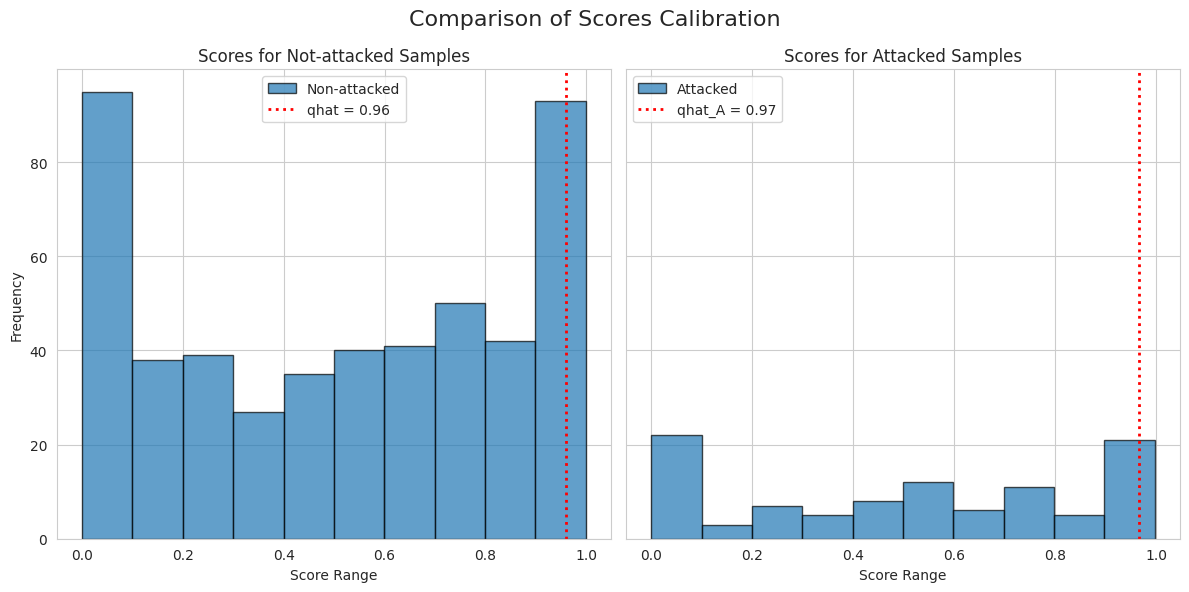

In [51]:
alpha = 0.1

q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl

qhat_VRCP = np.quantile(cl_cs_scores_VRCP, q_level, method='higher')
qhat_A_VRCP = np.quantile(cl_att_scores_VRCP, q_level, method='higher')

print('Classic quantile:', qhat_VRCP)
print('Attacked quantile:', qhat_A_VRCP)


fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axs[0].hist(cl_cs_scores_VRCP, bins=10, edgecolor='black', alpha=0.7, label='Non-attacked')
axs[0].axvline(x=qhat_VRCP, color='red', linestyle='dotted', linewidth=2, label=f'qhat = {qhat_VRCP:.2f}')
axs[0].set_title('Scores for Not-attacked Samples')
axs[0].set_xlabel('Score Range')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(cl_att_scores_VRCP, bins=10, edgecolor='black', alpha=0.7, label='Attacked')
axs[1].axvline(x=qhat_A_VRCP, color='red', linestyle='dotted', linewidth=2, label=f'qhat_A = {qhat_A_VRCP:.2f}')
axs[1].set_title('Scores for Attacked Samples')
axs[1].set_xlabel('Score Range')
axs[1].legend()

fig.suptitle(f'Comparison of Scores Calibration', fontsize=16)
plt.tight_layout()
plt.show()


### PERCP

Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


True label is in the conformal set for 91/100 test samples (91.00%).
24.587993144989014
Coverage std (0.29).
Number of conformal sets with size 1: 15
Number of conformal sets with size 2: 10
Number of conformal sets with size 3: 12
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 6
Number of conformal sets with size 11: 2
Number of conformal sets with size 12: 1
Number of conformal sets with size 13: 3
Number of conformal sets with size 14: 1
Number of conformal sets with size 16: 1
Average set size: 5.24
Std set size: 3.5046255149445
Plotting results...


Plotting calibration curve: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 859.72it/s]


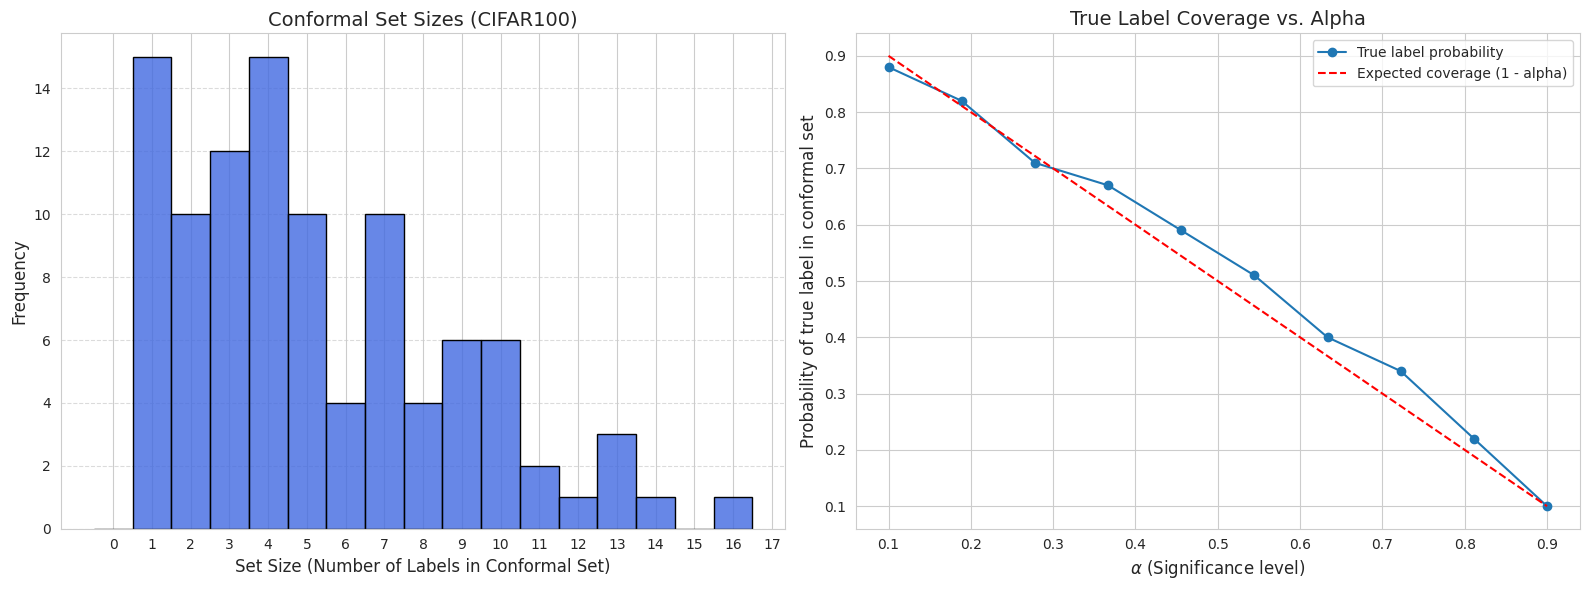

In [57]:
start_time = time.time()
att_conformal_sets_VRCP,att_score_list = compute_CP(ts_att_VRCP, qhat_A_VRCP, clf_VRCP)
att_coverage_VRCP = compute_covergae(ts, att_conformal_sets_VRCP)
end_time = time.time()
elapsed_time = end_time-start_time
print(elapsed_time)


att_coverage_var_VRCP = round(compute_covergae_std(ts, att_conformal_sets_VRCP),2)
att_sizes_VRCP = compute_set_sizes(ts, att_conformal_sets_VRCP)

att_size_mean_VRCP = mean_conformal_sets(att_conformal_sets_VRCP)
att_size_var_VRCP = std_conformal_sets(att_conformal_sets_VRCP)

plot_conformal_analysis(ts_att_VRCP, ts, att_sizes_VRCP, cl_att_scores_VRCP,att_score_list, clf_VRCP,  method = 'lac', steps = 10, dataset_name = "CIFAR100")

Plotting results...



Plotting calibration curve: 100%|██████████████████████████████████| 50/50 [00:00<00:00, 122.94it/s]


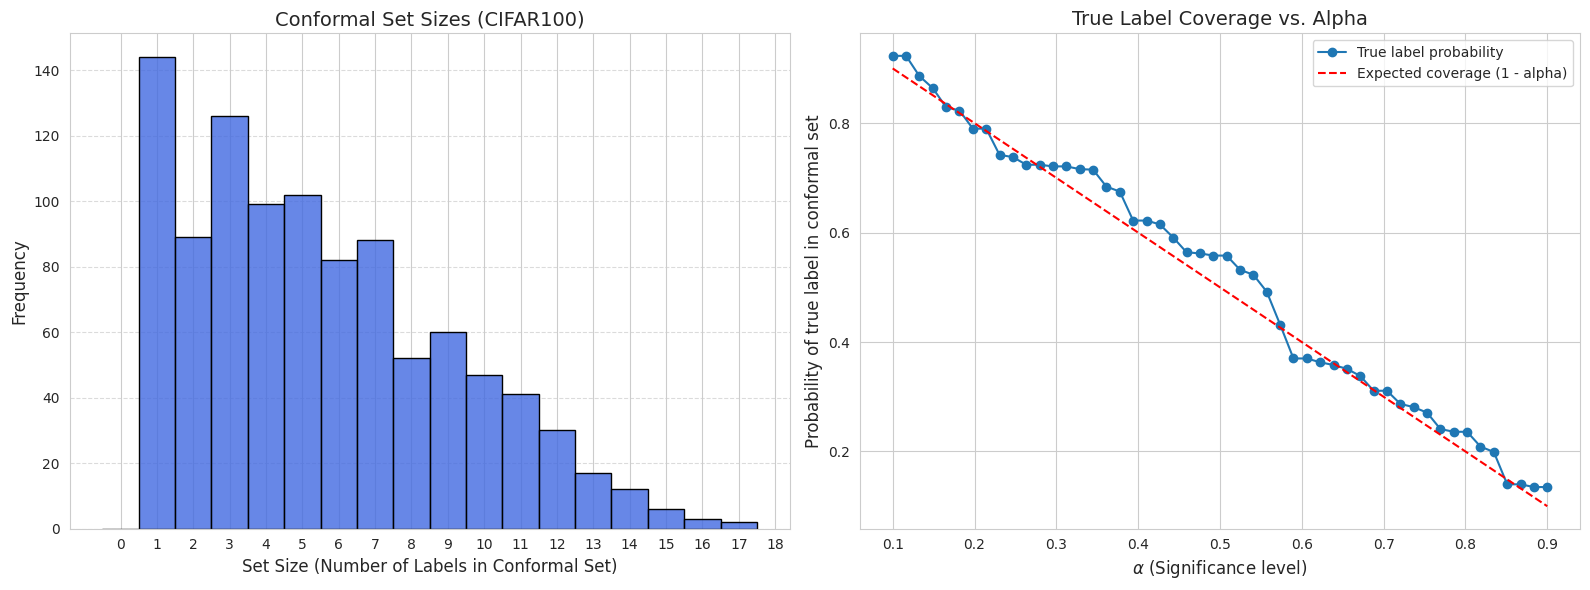

### Comparison Table with VRCP and RSCP

In [67]:
n_smooth = 1024 # 1 for linf, 1021 for l2 

base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/CIFAR100/VRCP_results/epsilon_0.02/sigma_model_0/sigma_smooth_0.04/n_smooth_1024/Robust/CNN"

# Loop through each epsilon and read the CSV file
file_path = os.path.join(base_path, "results_CI_noisy.csv")
df = pd.read_csv(file_path)
#print(df)

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

if os.path.exists(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    for method in ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]:
        # Extract the row corresponding to the method
        row = df[df['Method'] == method]

        if not row.empty:
            # Split the coverage and size columns into mean and std
            coverage = row['Coverage_CI'].values[0]
            size = row['Size_CI'].values[0]

            coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
            size_mean_val, size_std_val = map(float, size.split("±"))

            # Store the values
            coverage_mean[method].append(coverage_mean_val)
            coverage_std[method].append(coverage_std_val)
            size_mean[method].append(size_mean_val)
            size_std[method].append(size_std_val)
else:
    print(f"File not found: {file_path}")

coverage = [coverage_mean["HPS_vanilla"][0],
            coverage_mean["HPS_RSCP+"][0],
            coverage_mean["PTT_HPS_RSCP+"][0],
            coverage_mean["HPS_verif"][0],
            coverage_mean["HPS_verif_pre"][0],
            f"{att_coverage_VRCP / 100:.2f}"]

size = [size_mean["HPS_vanilla"][0],
        size_mean["HPS_RSCP+"][0],
        size_mean["PTT_HPS_RSCP+"][0],
        size_mean["HPS_verif"][0],
        size_mean["HPS_verif_pre"][0],
        att_size_mean_VRCP]

cov_std = [coverage_std["HPS_vanilla"][0],
           coverage_std["HPS_RSCP+"][0],
           coverage_std["PTT_HPS_RSCP+"][0],
           coverage_std["HPS_verif"][0],
           coverage_std["HPS_verif_pre"][0],
           att_coverage_var_VRCP] 

size_std = [size_std["HPS_vanilla"][0],
                 size_std["HPS_RSCP+"][0],
                 size_std["PTT_HPS_RSCP+"][0],
                 size_std["HPS_verif"][0],
                 size_std["HPS_verif_pre"][0],
                 att_size_var_VRCP]  # Example variances for each method

# Format the size column as "size ± variance"
coverage_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(coverage, cov_std)]

size_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(size, size_std)]
# Create DataFrame
df = pd.DataFrame({"Coverage": coverage_with_variance, "Size": size_with_variance}, index=["Vanilla", "RSCP+", "RSCP+(PTT)", "VRCP-I", "VRCP-C", "PERCP"])

# Display table
print(df)

# Save results

# Define the results folder
results_folder = "./Results"

# Ensure the folder exists
os.makedirs(results_folder, exist_ok=True)

# Define the full file path
output_file = os.path.join(results_folder, "Comparison_VRCP_CIFAR100.csv")

# Save the dataframe to CSV
df.to_csv(output_file, index=True)

print(f"File saved successfully at: {output_file}")

                 Coverage             Size
Vanilla     0.889 ± 0.008    7.815 ± 0.272
RSCP+         1.0 ± 0.000    100.0 ± 0.000
RSCP+(PTT)   0.93 ± 0.031  37.907 ± 26.564
VRCP-I      0.975 ± 0.004   25.125 ± 0.528
VRCP-C      0.986 ± 0.004   27.957 ± 1.729
PERCP        0.91 ± 0.290    3.767 ± 2.150
File saved successfully at: ./Results/Comparison_VRCP_CIFAR100.csv


## Multiple Splits

In [55]:
import time
import random

n_splits = 50
split_size = 100  # or any desired number < n_samples
    
size_list = []
coverage_list = []
time_list = [] 

for _ in range(n_splits):
    
    # Sample indices without replacement
    idx_cl = np.random.choice(n_cl, size=split_size, replace=False)
    idx_cl = CArray(idx_cl)
    # Sample from cl['X']
    sampled_cl = cl[idx_cl,:]

    # Sample from cl_att_VRCP as a list
    sampled_cl_att = [cl_att_VRCP[i.item()] for i in idx_cl.tondarray()]

    # Sample indices without replacement
    idx_ts = np.random.choice(n_ts, size=split_size, replace=False)
    idx_ts = CArray(idx_ts)
    # Sample from cl['X']
    sampled_ts = ts[idx_ts,:]

    # Sample from cl_att_VRCP as a list
    sampled_ts_att = [ts_att_VRCP[i.item()] for i in idx_ts.tondarray()]

    # Append the pair of samples
    splits.append((sample_ts, sample_ts_att))
    
    start_time = time.time() 
    
    cl_att_scores_VRCP = compute_score(sampled_cl, sampled_cl_att, clf_VRCP)
    ts_att_scores_VRCP = compute_score(sampled_ts, sampled_ts_att, clf_VRCP)
    
    qhat_A_VRCP = np.quantile(cl_att_scores_VRCP, q_level, method='higher')
    
    att_conformal_sets_VRCP,att_score_list = compute_CP(sampled_ts_att, qhat_A_VRCP, clf_VRCP)
    
    att_coverage_VRCP = compute_covergae(sampled_ts, att_conformal_sets_VRCP)

    att_sizes_VRCP = compute_set_sizes(sampled_ts, att_conformal_sets_VRCP)

    att_size_mean_VRCP = mean_conformal_sets(att_conformal_sets_VRCP)

    coverage_list.append(att_coverage_VRCP)
    size_list.append(att_size_mean_VRCP)
    
    end_time = time.time()  # <-- End timing
    time_elapsed = end_time - start_time
    time_list.append(time_elapsed)  # <-- Save time
    
att_size_mean_VRCP = np.mean(size_list)
att_size_var_VRCP = np.std(size_list)

att_coverage_VRCP = np.mean(coverage_list)
att_coverage_var_VRCP = np.std(coverage_list)

avg_time = np.mean(time_list)
std_time = np.std(time_list)

n_smooth = 1024 # 1 for linf, 1021 for l2 

base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/CIFAR100/VRCP_results/epsilon_0.02/sigma_model_0/sigma_smooth_0.04/n_smooth_1024/Robust/CNN"

# Loop through each epsilon and read the CSV file
file_path = os.path.join(base_path, "results_CI_noisy.csv")
df = pd.read_csv(file_path)
#print(df)

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

if os.path.exists(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    for method in ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]:
        # Extract the row corresponding to the method
        row = df[df['Method'] == method]

        if not row.empty:
            # Split the coverage and size columns into mean and std
            coverage = row['Coverage_CI'].values[0]
            size = row['Size_CI'].values[0]

            coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
            size_mean_val, size_std_val = map(float, size.split("±"))

            # Store the values
            coverage_mean[method].append(coverage_mean_val)
            coverage_std[method].append(coverage_std_val)
            size_mean[method].append(size_mean_val)
            size_std[method].append(size_std_val)
else:
    print(f"File not found: {file_path}")

coverage = [coverage_mean["HPS_vanilla"][0],
            coverage_mean["HPS_RSCP+"][0],
            coverage_mean["PTT_HPS_RSCP+"][0],
            coverage_mean["HPS_verif"][0],
            coverage_mean["HPS_verif_pre"][0],
            f"{att_coverage_VRCP / 100:.2f}"]

size = [size_mean["HPS_vanilla"][0],
        size_mean["HPS_RSCP+"][0],
        size_mean["PTT_HPS_RSCP+"][0],
        size_mean["HPS_verif"][0],
        size_mean["HPS_verif_pre"][0],
        att_size_mean_VRCP]

cov_std = [coverage_std["HPS_vanilla"][0],
           coverage_std["HPS_RSCP+"][0],
           coverage_std["PTT_HPS_RSCP+"][0],
           coverage_std["HPS_verif"][0],
           coverage_std["HPS_verif_pre"][0],
           att_coverage_var_VRCP] 

size_std = [size_std["HPS_vanilla"][0],
                 size_std["HPS_RSCP+"][0],
                 size_std["PTT_HPS_RSCP+"][0],
                 size_std["HPS_verif"][0],
                 size_std["HPS_verif_pre"][0],
                 att_size_var_VRCP]  # Example variances for each method

# Format the size column as "size ± variance"
coverage_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(coverage, cov_std)]

size_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(size, size_std)]
# Create DataFrame
df = pd.DataFrame({"Coverage": coverage_with_variance, "Size": size_with_variance}, index=["Vanilla", "RSCP+", "RSCP+(PTT)", "VRCP-I", "VRCP-C", "PERCP"])
df.loc["PERCP_time"] = [f"{avg_time:.2f} ± {std_time:.2f}", "N/A"]

# Display table
print(df)

# Save results

# Define the results folder
results_folder = "./Results_splits"

# Ensure the folder exists
os.makedirs(results_folder, exist_ok=True)

# Define the full file path
output_file = os.path.join(results_folder, "Comparison_VRCP_CIFAR100.csv")

# Save the dataframe to CSV
df.to_csv(output_file, index=True)

print(f"File saved successfully at: {output_file}")

Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 7
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 1
Average set size: 4.25


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


True label is in the conformal set for 92/100 test samples (92.00%).
Number of conformal sets with size 1: 14
Number of conformal sets with size 2: 10
Number of conformal sets with size 3: 11
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 8
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 7
Number of conformal sets with size 10: 3
Number of conformal sets with size 11: 3
Number of conformal sets with size 12: 2
Number of conformal sets with size 13: 2
Number of conformal sets with size 14: 3
Number of conformal sets with size 15: 1
Number of conformal sets with size 17: 1
Average set size: 5.63


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.17it/s]


True label is in the conformal set for 91/100 test samples (91.00%).
Number of conformal sets with size 1: 15
Number of conformal sets with size 2: 11
Number of conformal sets with size 3: 11
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 3
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 7
Number of conformal sets with size 11: 1
Number of conformal sets with size 12: 2
Number of conformal sets with size 13: 2
Number of conformal sets with size 14: 1
Number of conformal sets with size 16: 1
Average set size: 5.2


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 12
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 1
Average set size: 4.24


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 3
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 4
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 1
Average set size: 4.42


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 8
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 3
Average set size: 4.13


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 8
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 3
Average set size: 4.12


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


True label is in the conformal set for 92/100 test samples (92.00%).
Number of conformal sets with size 1: 14
Number of conformal sets with size 2: 10
Number of conformal sets with size 3: 11
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 8
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 7
Number of conformal sets with size 10: 3
Number of conformal sets with size 11: 3
Number of conformal sets with size 12: 2
Number of conformal sets with size 13: 2
Number of conformal sets with size 14: 3
Number of conformal sets with size 15: 1
Number of conformal sets with size 17: 1
Average set size: 5.63


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 8
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 3
Average set size: 4.13


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.17it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 31
Number of conformal sets with size 2: 17
Number of conformal sets with size 3: 24
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 1
Average set size: 2.7


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 28
Number of conformal sets with size 2: 18
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 17
Number of conformal sets with size 6: 5
Number of conformal sets with size 7: 2
Average set size: 2.98


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.20it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 5
Number of conformal sets with size 7: 9
Number of conformal sets with size 8: 8
Number of conformal sets with size 9: 4
Number of conformal sets with size 10: 6
Number of conformal sets with size 11: 2
Average set size: 4.56


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 20
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 10
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 2
Average set size: 4.01


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 23
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 13
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 11
Number of conformal sets with size 7: 6
Number of conformal sets with size 8: 2
Number of conformal sets with size 9: 1
Average set size: 3.51


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


True label is in the conformal set for 90/100 test samples (90.00%).
Number of conformal sets with size 1: 16
Number of conformal sets with size 2: 10
Number of conformal sets with size 3: 12
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 5
Number of conformal sets with size 7: 8
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 2
Number of conformal sets with size 12: 3
Number of conformal sets with size 13: 1
Number of conformal sets with size 15: 1
Average set size: 5.04


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 20
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 9
Number of conformal sets with size 6: 13
Number of conformal sets with size 7: 9
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 1
Average set size: 3.92


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 28
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 18
Number of conformal sets with size 6: 5
Number of conformal sets with size 7: 2
Average set size: 3.02


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 1
Average set size: 4.46


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.20it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 17
Number of conformal sets with size 2: 11
Number of conformal sets with size 3: 12
Number of conformal sets with size 4: 13
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 5
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 4
Number of conformal sets with size 12: 3
Average set size: 4.89


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 23
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 15
Number of conformal sets with size 6: 8
Number of conformal sets with size 7: 6
Number of conformal sets with size 8: 1
Number of conformal sets with size 9: 1
Average set size: 3.43


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 9
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 7
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 2
Number of conformal sets with size 10: 3
Number of conformal sets with size 11: 1
Average set size: 4.18


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.27it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 8
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 3
Average set size: 4.12


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 7
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 1
Average set size: 4.25


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 31
Number of conformal sets with size 2: 17
Number of conformal sets with size 3: 24
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 1
Average set size: 2.7


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


True label is in the conformal set for 94/100 test samples (94.00%).
Number of conformal sets with size 1: 10
Number of conformal sets with size 2: 6
Number of conformal sets with size 3: 7
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 1
Number of conformal sets with size 8: 3
Number of conformal sets with size 9: 5
Number of conformal sets with size 10: 8
Number of conformal sets with size 11: 6
Number of conformal sets with size 12: 5
Number of conformal sets with size 13: 3
Number of conformal sets with size 14: 3
Number of conformal sets with size 16: 2
Number of conformal sets with size 17: 3
Number of conformal sets with size 18: 1
Number of conformal sets with size 19: 3
Number of conformal sets with size 20: 1
Number of conformal sets with size 21: 2
Number of conformal sets with size 23: 1
Number of conformal sets with size 25: 1
Average set size: 8.15


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 9
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 7
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 2
Number of conformal sets with size 10: 3
Number of conformal sets with size 11: 1
Average set size: 4.18


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 9
Number of conformal sets with size 5: 12
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 9
Number of conformal sets with size 8: 8
Number of conformal sets with size 9: 5
Number of conformal sets with size 10: 6
Number of conformal sets with size 11: 1
Average set size: 4.52


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 7
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 1
Average set size: 4.25


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 9
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 7
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 1
Average set size: 4.2


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 28
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 13
Number of conformal sets with size 5: 19
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 2
Average set size: 3.05


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 27
Number of conformal sets with size 2: 14
Number of conformal sets with size 3: 18
Number of conformal sets with size 4: 12
Number of conformal sets with size 5: 17
Number of conformal sets with size 6: 9
Number of conformal sets with size 7: 3
Average set size: 3.17


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 30
Number of conformal sets with size 2: 18
Number of conformal sets with size 3: 20
Number of conformal sets with size 4: 14
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 1
Average set size: 2.78


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 21
Number of conformal sets with size 2: 14
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 11
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 1
Average set size: 3.83


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


True label is in the conformal set for 81/100 test samples (81.00%).
Number of conformal sets with size 1: 41
Number of conformal sets with size 2: 28
Number of conformal sets with size 3: 22
Number of conformal sets with size 4: 8
Number of conformal sets with size 6: 1
Average set size: 2.01


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 23
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 13
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 11
Number of conformal sets with size 7: 6
Number of conformal sets with size 8: 2
Number of conformal sets with size 9: 1
Average set size: 3.51


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 17
Number of conformal sets with size 2: 11
Number of conformal sets with size 3: 12
Number of conformal sets with size 4: 13
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 5
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 4
Number of conformal sets with size 12: 3
Average set size: 4.89


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 21
Number of conformal sets with size 2: 14
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 11
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 1
Average set size: 3.83


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 21
Number of conformal sets with size 2: 14
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 11
Number of conformal sets with size 6: 11
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 1
Average set size: 3.83


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.17it/s]


True label is in the conformal set for 91/100 test samples (91.00%).
Number of conformal sets with size 1: 15
Number of conformal sets with size 2: 10
Number of conformal sets with size 3: 12
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 6
Number of conformal sets with size 11: 2
Number of conformal sets with size 12: 1
Number of conformal sets with size 13: 3
Number of conformal sets with size 14: 1
Number of conformal sets with size 16: 1
Average set size: 5.24


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 1
Average set size: 4.46


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 3
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 4
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 1
Average set size: 4.42


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 1
Average set size: 4.46


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.25it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 20
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 9
Number of conformal sets with size 6: 13
Number of conformal sets with size 7: 9
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 1
Average set size: 3.92


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 16
Number of conformal sets with size 3: 14
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 8
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 3
Average set size: 4.13


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 18
Number of conformal sets with size 2: 13
Number of conformal sets with size 3: 16
Number of conformal sets with size 4: 8
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 11
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 1
Average set size: 4.46


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


True label is in the conformal set for 89/100 test samples (89.00%).
Number of conformal sets with size 1: 19
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 7
Number of conformal sets with size 5: 13
Number of conformal sets with size 6: 6
Number of conformal sets with size 7: 12
Number of conformal sets with size 8: 5
Number of conformal sets with size 9: 3
Number of conformal sets with size 10: 4
Number of conformal sets with size 11: 1
Average set size: 4.25


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


True label is in the conformal set for 92/100 test samples (92.00%).
Number of conformal sets with size 1: 15
Number of conformal sets with size 2: 9
Number of conformal sets with size 3: 11
Number of conformal sets with size 4: 12
Number of conformal sets with size 5: 12
Number of conformal sets with size 6: 5
Number of conformal sets with size 7: 8
Number of conformal sets with size 8: 7
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 5
Number of conformal sets with size 11: 2
Number of conformal sets with size 12: 2
Number of conformal sets with size 13: 3
Number of conformal sets with size 14: 2
Number of conformal sets with size 16: 1
Average set size: 5.49


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


True label is in the conformal set for 87/100 test samples (87.00%).
Number of conformal sets with size 1: 31
Number of conformal sets with size 2: 17
Number of conformal sets with size 3: 24
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 14
Number of conformal sets with size 6: 2
Number of conformal sets with size 7: 1
Average set size: 2.7


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


True label is in the conformal set for 88/100 test samples (88.00%).
Number of conformal sets with size 1: 20
Number of conformal sets with size 2: 15
Number of conformal sets with size 3: 15
Number of conformal sets with size 4: 11
Number of conformal sets with size 5: 9
Number of conformal sets with size 6: 13
Number of conformal sets with size 7: 9
Number of conformal sets with size 8: 6
Number of conformal sets with size 9: 1
Number of conformal sets with size 10: 1
Average set size: 3.92


Computing CP sets: 100%|██████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]

True label is in the conformal set for 91/100 test samples (91.00%).
Number of conformal sets with size 1: 15
Number of conformal sets with size 2: 10
Number of conformal sets with size 3: 12
Number of conformal sets with size 4: 15
Number of conformal sets with size 5: 10
Number of conformal sets with size 6: 4
Number of conformal sets with size 7: 10
Number of conformal sets with size 8: 4
Number of conformal sets with size 9: 6
Number of conformal sets with size 10: 6
Number of conformal sets with size 11: 2
Number of conformal sets with size 12: 1
Number of conformal sets with size 13: 3
Number of conformal sets with size 14: 1
Number of conformal sets with size 16: 1
Average set size: 5.24
                 Coverage             Size
Vanilla     0.889 ± 0.008    7.815 ± 0.272
RSCP+         1.0 ± 0.000    100.0 ± 0.000
RSCP+(PTT)   0.93 ± 0.031  37.907 ± 26.564
VRCP-I      0.975 ± 0.004   25.125 ± 0.528
VRCP-C      0.986 ± 0.004   27.957 ± 1.729
PERCP        0.89 ± 1.870   4.1682 ± 0

### Multiple Attacks: PGD 1,10,100
### Check Verifiers' and Randomizers' coverage and size curves

In [6]:
epsilons_VRCP = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

epsilons = np.linspace(0.1,7.0,50)
extended_epsilons =epsilons_VRCP + list(epsilons)  

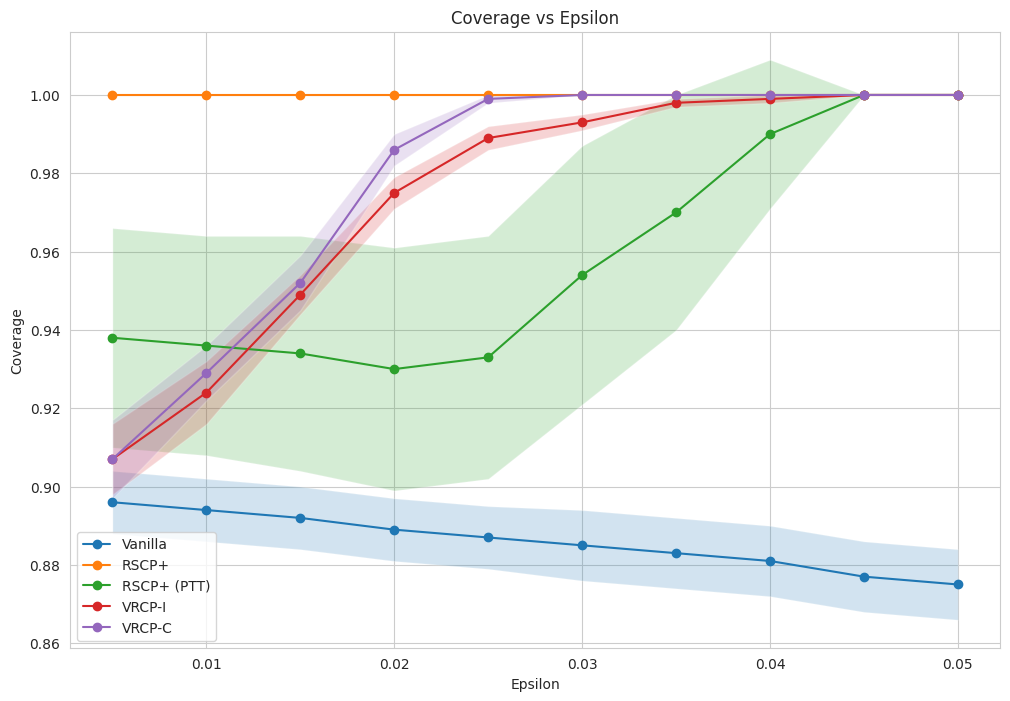

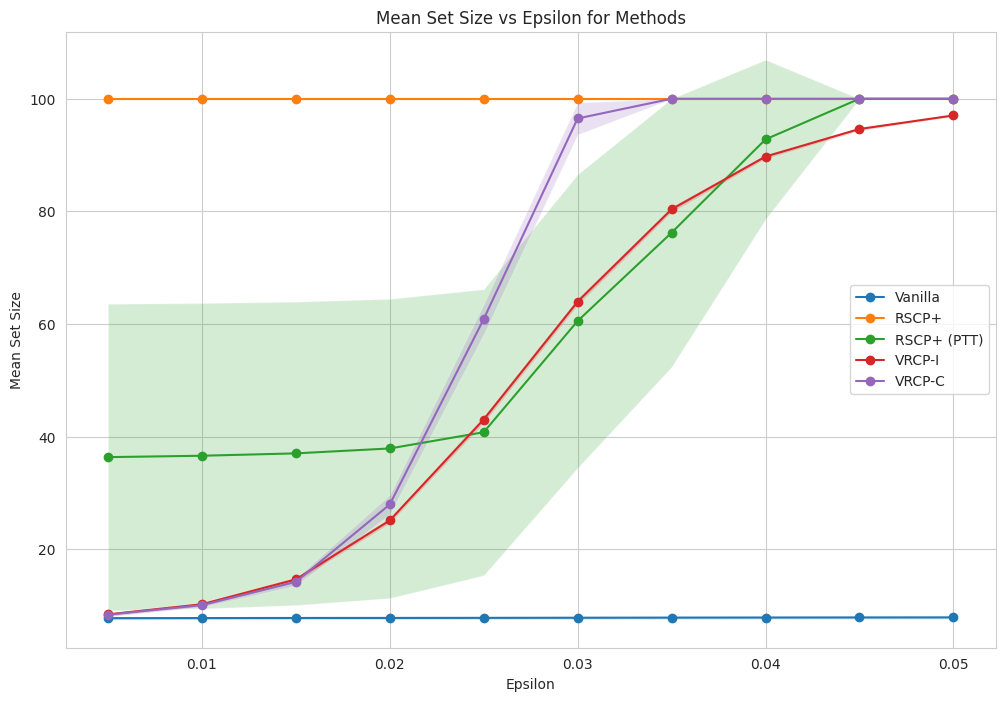

In [66]:
# Define the base path and epsilon values
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/CIFAR100/VRCP_results"
sigma_model = 0
sigma_smooth = 0.01
n_smooth = 1024 # 1 for linf, 1021 for l2

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

methods = ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]
label_methods = ["Vanilla", "RSCP+", "RSCP+ (PTT)","VRCP-I", "VRCP-C"]
# Loop through each epsilon and read the CSV file
for eps in epsilons_VRCP:
    file_path = os.path.join(
        base_path, f"epsilon_{eps}", f"sigma_model_{sigma_model}", f"sigma_smooth_{eps*2}",
        f"n_smooth_{n_smooth}", "Robust", "CNN", "results_CI_noisy.csv"
)
            
    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)

        for method in methods:
            # Extract the row corresponding to the method
            row = df[df['Method'] == method]
            if not row.empty:
                # Split the coverage and size columns into mean and std
                coverage = row['Coverage_CI'].values[0]
                size = row['Size_CI'].values[0]

                coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
                size_mean_val, size_std_val = map(float, size.split("±"))

                # Store the values
                coverage_mean[method].append(coverage_mean_val)
                coverage_std[method].append(coverage_std_val)
                size_mean[method].append(size_mean_val)
                size_std[method].append(size_std_val)
    else:
        print(f"File not found: {file_path}")

# Plot Coverage with Shaded Regions
plt.figure(figsize=(12, 8))
for method,label_method in zip(methods, label_methods):
    
    plt.plot(epsilons_VRCP, coverage_mean[method], label=label_method, marker='o')

    plt.fill_between(epsilons_VRCP,
                     np.array(coverage_mean[method]) - np.array(coverage_std[method]),
                     np.array(coverage_mean[method]) + np.array(coverage_std[method]),
                     alpha=0.2)

plt.xlabel("Epsilon")
plt.ylabel("Coverage")
plt.title("Coverage vs Epsilon")
plt.legend()
plt.grid(True)
plt.savefig("coverage_plot.png")
plt.show()

# Plot Size with Shaded Regions
plt.figure(figsize=(12, 8))
for method,label_method in zip(methods, label_methods):
    plt.plot(epsilons_VRCP, size_mean[method], label=f'{label_method}', marker='o')
    plt.fill_between(epsilons_VRCP,
                     np.array(size_mean[method]) - np.array(size_std[method]),
                     np.array(size_mean[method]) + np.array(size_std[method]),
                     alpha=0.2)

plt.xlabel("Epsilon")
plt.ylabel("Mean Set Size")
plt.title("Mean Set Size vs Epsilon for Methods")
plt.legend()
plt.grid(True)
plt.savefig("size_plot.png")
plt.show()


In [4]:
import os
import shutil
import csv
import numpy as np

def evaluate_attacks(model_name, norm_name, attack_configs, extended_epsilons, cl, ts, clf, alpha=0.1, base_output_dir="./Results"):
    """
    Evaluate different adversarial attacks on a given model and dataset,
    adapting attack parameters based on different epsilon values.
    """
    n_cl = cl.X.shape[0]

    for eps in extended_epsilons:
        # Adjust attack parameters for each epsilon value
        new_configs = []
        for attack in attack_configs:
            steps = attack["steps"]
            new_attack = attack.copy()
            new_attack["epsilon"] = eps
            new_attack["step_size"] = eps / steps if steps > 0 else attack["step_size"]
            new_configs.append(new_attack)
            
        save_path = os.path.join(base_output_dir, model_name, norm_name,f"eps_{eps:.4f}")
        
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        os.makedirs(save_path, exist_ok=True)
        
        csv_file = os.path.join(save_path, "results.csv")
    
        # Run attacks
        cl_att_dict = attack_dataset(cl, clf, new_configs, desc="Running attacks", n_jobs=1)
        ts_att_dict = attack_dataset(ts, clf, new_configs, desc="Running attacks", n_jobs=1)
        
        if isinstance(cl_att_dict,dict):
        
            for attack_type in cl_att_dict.keys():

                cl_att = cl_att_dict[attack_type]
                ts_att = ts_att_dict[attack_type]

                cl_att_scores = compute_score(cl, cl_att, clf_VRCP)

                # Get quantile
                q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl
                qhat_A = np.quantile(cl_att_scores, q_level, method='higher')

                # Conformal sets
                att_conformal_sets,_ = compute_CP(ts_att, qhat_A, clf_VRCP)
                # Compute coverage and variance
                att_coverage = compute_covergae(ts, att_conformal_sets)
                att_coverage_var = compute_covergae_std(ts, att_conformal_sets)

                # Compute mean and variance of set sizes
                att_size_mean = mean_conformal_sets(att_conformal_sets)
                att_size_var = std_conformal_sets(att_conformal_sets) / 10

                # Store results
                results = [
                    {  
                        "attack_type": f"{attack_type}",
                        "coverage": f"{att_coverage:.4f} ± {att_coverage_var:.4f}",
                        "size": f"{att_size_mean:.4f} ± {att_size_var:.4f}"
                    }
                ]

                # Save results to CSV 
                file_exists = os.path.isfile(csv_file)
                with open(csv_file, mode="a", newline="") as file:
                    writer = csv.DictWriter(file, fieldnames=["attack_type", "coverage", "size"])
                    if not file_exists:
                        writer.writeheader()  # Write header only if the file is new
                    writer.writerows(results)

                print(f"Results saved to {csv_file}")
        else:

            attack_type = get_single_attack_key(new_configs[0])

            cl_att = cl_att_dict
            ts_att = ts_att_dict

            cl_att_scores = compute_score(cl, cl_att, clf_VRCP)

            # Get quantile
            q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl
            qhat_A = np.quantile(cl_att_scores, q_level, method='higher')

            # Conformal sets
            att_conformal_sets,_ = compute_CP(ts_att, qhat_A, clf_VRCP)
            # Compute coverage and variance
            att_coverage = compute_covergae(ts, att_conformal_sets)
            att_coverage_var = compute_covergae_std(ts, att_conformal_sets)

            # Compute mean and variance of set sizes
            att_size_mean = mean_conformal_sets(att_conformal_sets)
            att_size_var = std_conformal_sets(att_conformal_sets) / 10


            # Store results
            results = [
                {  
                    "attack_type": f"{attack_type}",
                    "coverage": f"{att_coverage:.4f} ± {att_coverage_var:.4f}",
                    "size": f"{att_size_mean:.4f} ± {att_size_var:.4f}"
                }
            ]

            # Save results to CSV 
            file_exists = os.path.isfile(csv_file)
            with open(csv_file, mode="a", newline="") as file:
                writer = csv.DictWriter(file, fieldnames=["attack_type", "coverage", "size"])
                if not file_exists:
                    writer.writeheader()  # Write header only if the file is new
                writer.writerows(results)

            print(f"Results saved to {csv_file}")


In [ ]:
model_name = "VRCP"
norm_name = "l2"


attack_configs = [
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 1, "distance": "l2", "lb": 0.0, "ub": 1.0},
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 10, "distance": "l2", "lb": 0.0, "ub": 1.0},
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 100, "distance": "l2", "lb": 0.0, "ub": 1.0}

]

evaluate_attacks(model_name, norm_name, attack_configs, extended_epsilons, cl, ts, clf_VRCP, alpha=0.1, base_output_dir="./Results_7")

Running attacks:  30%|██▉       | 148/500 [11:40<28:06,  4.79s/sample]

In [127]:
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/CIFAR100/Results/VRCP/l2"

results_dict = {}

for eps in extended_epsilons:

    file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  

    if  os.path.isfile(file_path):
        file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  
    #else:
    #    file_path = os.path.join(base_path_VRCP_eps, f"eps_{eps:.4f}", "results.csv") 

    config_results_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            # Skip the header or any empty lines
            if line.lower().startswith("attack_type"):
                continue

            # Split each line into columns based on commas
            cols = line.strip().split(',')

            if len(cols) >= 3:
                attack_type = cols[0].strip()
                coverage = cols[1].strip()
                size = cols[2].strip()

                # Extract mean and std values for coverage and size
                coverage_mean, coverage_std = map(float, coverage.split("±"))
                size_mean, size_std = map(float, size.split("±"))


            # Store the results in the dictionary
                config_results_dict[attack_type] = {
                    "coverage_mean": coverage_mean,
                    "coverage_std": coverage_std,
                    "size_mean": size_mean,
                    "size_std": size_std,
                }

            else:
                print(f"File not found: {file_path}")

        results_dict[f"{eps:.4f}"] = config_results_dict
        
print("Data loaded in the dictionary.")
print(" ")
print("The following attacks are available")
print(" ")
attack_names = list(next(iter(results_dict.values())).keys())
print(attack_names)

Data loaded in the dictionary.
 
The following attacks are available
 
['combined', 'PGD_1_l2', 'PGD_10_l2', 'PGD_100_l2']


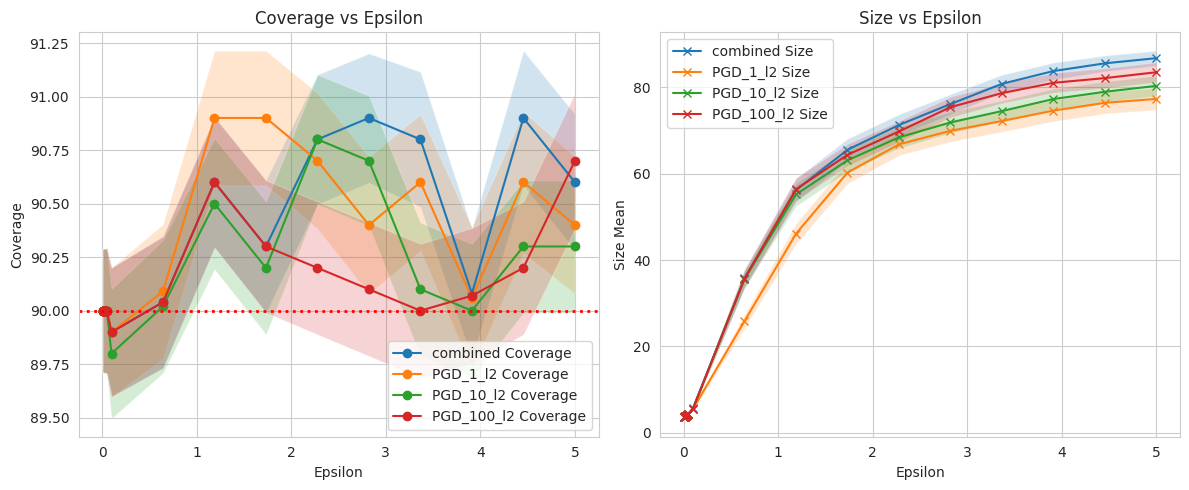

In [128]:

# Define figure
plt.figure(figsize=(12, 5))

# Set reference value for 1 - alpha
one_minus_alpha_ref = (1 - alpha) * 100  # Convert to percentage

for attack_name in attack_names:

    # Extract coverage and size mean/std for each epsilon
    coverage = [results_dict[f"{eps:.4f}"][attack_name]['coverage_mean'] for eps in extended_epsilons]
    size = [results_dict[f"{eps:.4f}"][attack_name]['size_mean'] for eps in extended_epsilons]

    coverage_std = [results_dict[f"{eps:.4f}"][attack_name]['coverage_std'] for eps in extended_epsilons]
    size_std = [results_dict[f"{eps:.4f}"][attack_name]['size_std'] for eps in extended_epsilons]

    # Convert to NumPy arrays for plotting
    epsilons_np = np.array(extended_epsilons)
    coverage_np, coverage_std_np = np.array(coverage), np.array(coverage_std)
    size_np, size_std_np = np.array(size), np.array(size_std)

    # Plot Coverage vs Epsilon
    plt.subplot(1, 2, 1)
    plt.plot(epsilons_np, coverage_np, label=f'{attack_name} Coverage', marker='o')  # Convert coverage to percentage
    plt.fill_between(epsilons_np, (coverage_np - coverage_std_np), (coverage_np + coverage_std_np), alpha=0.2)

    # Plot Size vs Epsilon
    plt.subplot(1, 2, 2)
    plt.plot(epsilons_np, size_np, label=f'{attack_name} Size', marker='x')
    plt.fill_between(epsilons_np, size_np - size_std_np, size_np + size_std_np, alpha=0.2)

# Add horizontal red line at (1 - α) * 100 on the coverage plot
plt.subplot(1, 2, 1)
plt.axhline(y=one_minus_alpha_ref, color='r', linestyle='dotted', linewidth=2)

# Add label on the y-axis at (1 - α) * 100
plt.subplot(1, 2, 1)
plt.ylabel('Coverage')  # Base y-axis label
#plt.text(x=epsilons_np[0] - (epsilons_np[-1] - epsilons_np[0]) * 0.1,  # Shift left of y-axis
#         y=one_minus_alpha_ref, 
#         s=f'{one_minus_alpha_ref:.1f}', 
#         color='r', fontsize=10, verticalalignment='center', horizontalalignment='right')

# Customize plot appearance
plt.subplot(1, 2, 1)
plt.xlabel('Epsilon')
plt.title('Coverage vs Epsilon')
plt.legend()
#plt.ylim(0.0, 100.0)  # Ensure it's between 0 and 100
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlabel('Epsilon')
plt.ylabel('Size Mean')
plt.title('Size vs Epsilon')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save and show the plot
plt.savefig('coverage_size_plot.png', dpi=300)
plt.show()
